# ORTHOGONAL POLYNOMIAL DENSITY ESTIMATION
## Preliminaries
### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
from uuid import uuid4

from lpde.geometry import WidthOf, Window, PointAt, BoundingBox, Mapper, Grid
from lpde.estimators import SerialEstimator
from lpde.estimators.datatypes import Event, Degree, Action, Scalings

### Notebook settings

In [2]:
%matplotlib notebook

## Density Estimation
### Initialize

In [3]:
legendre_width = WidthOf(1.8)

center = PointAt(0, 0)
window = Window(1.8, 1.8)
bounds = BoundingBox(center, window)

mapper = Mapper(bounds, legendre_width)

degree = Degree(20, 20)
density = SerialEstimator(degree, mapper)

action = Action.ADD
point = PointAt(0.5, 0.5)
event = Event(uuid4(), action, point)

grid = Grid(100, 100)

### Create mock data streams

In [4]:
def gaussian():
    x, y = np.random.multivariate_normal((0,0), ((0.1,0), (0,0.1)))
    if (-0.9 <= x <= 0.9) and (-0.9 <= y <= 0.9):
        return x, y
    else:
        return gaussian()

def uniform():
    return np.random.uniform(low=-0.9, high=0.9, size=2)

locations = []

def new_event(dist):
    location = dist()
    locations.append(location)
    point = PointAt(*location)
    return Event(uuid4(), Action(1), point)

def random_event(dist):
    event_type = np.random.randint(low=-1, high=2)
    if event_type == 1:
        location = dist()
        point = PointAt(*location)
        return Event(uuid4(), Action(1), point)
    elif event_type == 0:
        location = dist()
        point = PointAt(*location)
        column = density._phi.sample(1, axis=1).columns.values[0]
        return Event(column, Action(0), point)
    column = density._phi.sample(1, axis=1).columns.values[0]
    return Event(column, Action(-1))

### Timings of density estimation

In [5]:
%%time
for i in range(1000):
    density.update_with(new_event(gaussian))

/home/georg/Documents/Python/LPDE/lpde/estimators/serial/serial.py:97: RuntimeWarning: overflow encountered in double_scalars
  return self.__neg_log_l(c[1:]) + c[0]*self.__norm(c[1:])


CPU times: user 5min 28s, sys: 7.47 s, total: 5min 36s
Wall time: 42.1 s


In [ ]:
%%time
for i in range(1000):
    density.at(new_event(uniform).location)

__Timings__

33 ms per additive update with uniform distribution

31 ms per random update with uniform distribution

0.6 ms per evaluation at point

### Plot final density

<IPython.core.display.Javascript object>


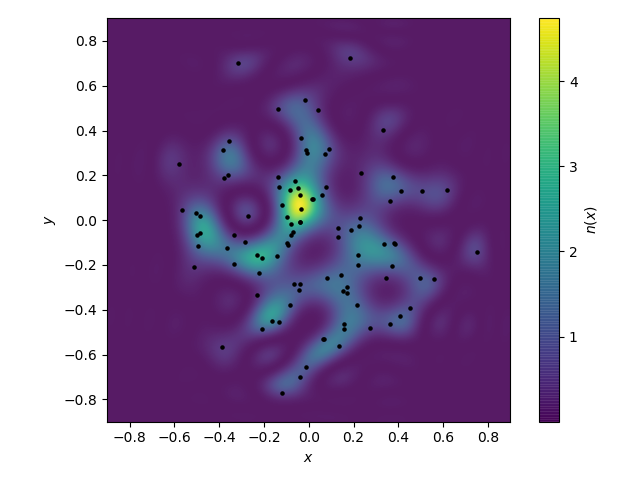

In [7]:
n_hat = density.on(grid)

fig, ax = plt.subplots()
ax.set(xlabel=r'$x$', ylabel=r'$y$')
ax.scatter(*zip(*locations), s=5, c='k')
contour = ax.imshow(n_hat,
                    cmap='viridis',
                    alpha=0.9,
                    extent=2*mapper.legendre_interval,
                    origin='lower',
                    interpolation='bicubic')
cbar = plt.colorbar(contour, ax=ax, label=r'$n(x)$')
fig.tight_layout()

## Coefficient smoothing

In [ ]:
coeffs = []

for i in range(1000):
    density.update_with(new_event(gaussian))
    coeffs.append(density._c.tolist())  

coeffs = np.array(coeffs).T

In [ ]:
ij = 1

fig, ax = plt.subplots()
ax.plot(coeffs[ij])

In [ ]:
def filtered(x, a):
    result = np.zeros_like(x)
    for i in range(1, len(x)):
        result[i] = a*x[i] + (1-a)*result[i-1]
    return result

In [ ]:
fig, ax = plt.subplots()
ax.plot(filtered(test, 0.1))

In [ ]:
test = np.ones(100)
test = np.append(np.zeros(100), test)
test = np.append(test, np.zeros(100))

In [ ]:
import scipy.signal as scps

In [ ]:
b, a = scps.butter(2, 0.03)
plt.plot(scps.lfilter(b, a, coeffs[ij]))

In [ ]:
b